# Denoising autoencoder on MNIST

Simple example of applying a denoising autoencoder to the MNIST dataset using TensorFlow.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load MNIST dataset using Google's `input_data` file from: https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/g3doc/tutorials/mnist/input_data.py

In [2]:
import input_data # https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/g3doc/tutorials/mnist/input_data.py
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Startup a TF session

In [3]:
import tensorflow as tf
s = tf.InteractiveSession()

Create `placeholder` variable for the input data

In [4]:
x = tf.placeholder(tf.float32, shape=(None, 784))

In [8]:
n_hidden = 1000
n_vis = 784
nonlinearity = tf.nn.softplus

noise = tf.random_normal(tf.array_ops.shape(x), stddev=0.25)
xnoise = tf.nn.dropout(x, 0.8)
xnoise = xnoise + noise
#xnoise = x
Wenc = tf.Variable(tf.truncated_normal((n_vis, n_hidden), stddev=0.02), name="Wenc")
benc = tf.Variable(tf.truncated_normal((n_hidden,), stddev=0.001), name="benc")
h = tf.matmul(xnoise, Wenc)
noise = tf.random_normal(tf.array_ops.shape(h), stddev=1.5)
#h = h - tf.reduce_mean(h, 1, keep_dims=True)
h = h + noise
h = nonlinearity(h)
#h = tf.nn.dropout(h, 0.5)
#h = h - tf.reduce_mean(h, 0, keep_dims=True)
Wdec = tf.Variable(tf.truncated_normal((n_hidden, n_vis), stddev=0.02), name="Wdec")
bdec = tf.Variable(tf.truncated_normal((n_vis,), stddev=0.001), name="bdec")
logits = (tf.matmul(h, Wdec) + bdec)#, name=scope.name)
xhat = logits#tf.nn.sigmoid(logits)

In [9]:
#recon_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, x))
recon_cost = tf.reduce_mean(tf.square(xhat - x))
cost = recon_cost

Create a ``train_step`` op that computes the gradients and applies updates to all variables that influence `cost`

In [10]:
lr = 0.001
train_step = tf.train.AdamOptimizer(lr).minimize(cost)

Initialize variables. Note that Adam creates additional variables, so this must be run after the training op is created, but before it is used.

In [11]:
s.run(tf.initialize_all_variables())

Train the model!

In [ ]:
%%time
outputs = []
iters = 50000
from progressbar import ProgressBar
progress = ProgressBar()
normalize_w = tf.assign(Wenc, tf.div(Wenc, tf.sqrt(tf.reduce_sum(tf.square(Wenc), 0, keep_dims=True))))
for i in progress(xrange(iters)):
    batch = mnist.train.next_batch(64)
    #train_step.run({x: batch[0], y_: batch[1]})
    _, l = s.run([train_step, recon_cost], {x: batch[0]})
    if (i % 10) == 0:
        normalize_w.eval()
    outputs.append(l)

 35% (17514 of 50000) |######             | Elapsed Time: 0:01:20 ETA:  0:02:28

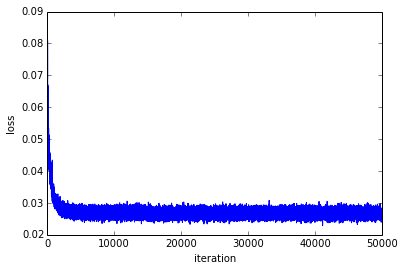

In [17]:
loss = np.array(outputs)
plot(loss[100:])
xlabel('iteration')
ylabel('loss')
#plot(sparsity[100:])

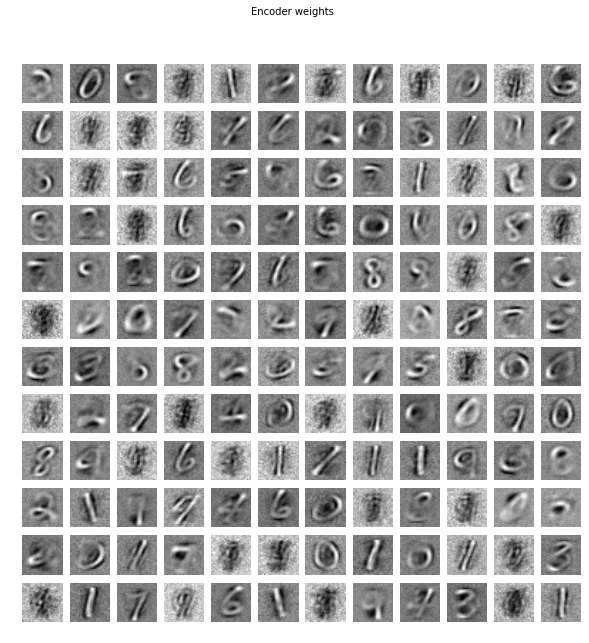

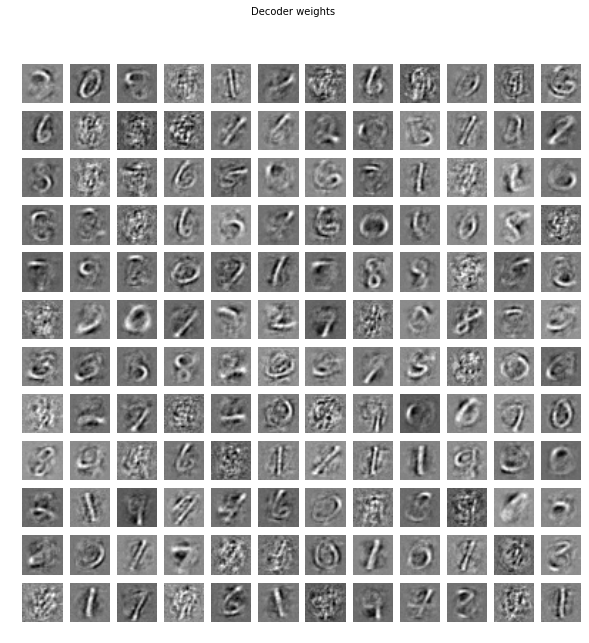

In [21]:
n_max = 144
wdec = tf.transpose(Wdec).eval().reshape(28, 28, -1)[..., :n_max]
wenc = Wenc.eval().reshape(28, 28, -1)[..., :n_max]

def show_filters(w):
    n = w.shape[-1]
    rows = int(np.ceil(np.sqrt(n)))
    cols = int(np.ceil(float(n) / rows))
    for i in xrange(n):
        subplot(rows, cols, i + 1)
        imshow(w[..., i], cmap=cm.gray)
        axis('off')
        
figure(figsize=(10, 10))
show_filters(wenc)
suptitle('Encoder weights')
show()

figure(figsize=(10, 10))
show_filters(wdec)
suptitle('Decoder weights')

In [19]:
xstar = batch[0][:10]
xpred = xhat.eval({x: xstar})

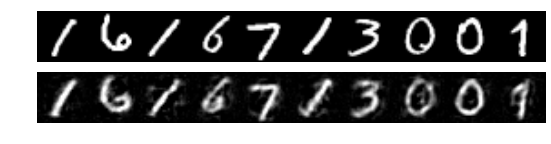

In [20]:
figure(figsize=(10,2))
subplot(211)
imshow(np.hstack(xstar.reshape(-1, 28, 28)), vmin=0, vmax=1, cmap=cm.gray)
axis('off')
ylabel('input')
subplot(212)
imshow(np.hstack(xpred.reshape(-1, 28, 28)), vmin=0, vmax=1, cmap=cm.gray)
axis('off')
ylabel('recon')